Adapted from:
- [https://maker.pro/raspberry-pi/tutorial/grid-detection-with-opencv-on-raspberry-pi](https://maker.pro/raspberry-pi/tutorial/grid-detection-with-opencv-on-raspberry-pi)
- [https://stackoverflow.com/questions/48954246/find-sudoku-grid-using-opencv-and-python](https://stackoverflow.com/questions/48954246/find-sudoku-grid-using-opencv-and-python)
- [https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)
- [https://aishack.in/tutorials/sudoku-grabber-opencv-plot/](https://aishack.in/tutorials/sudoku-grabber-opencv-plot/)


In [294]:
# Notebooks can't display cv2 images natively, so we use this function to display them inline instead of cv2.imshow()

import io
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

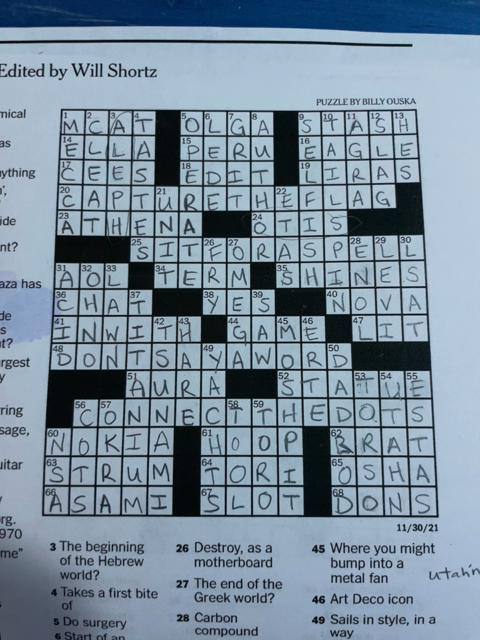

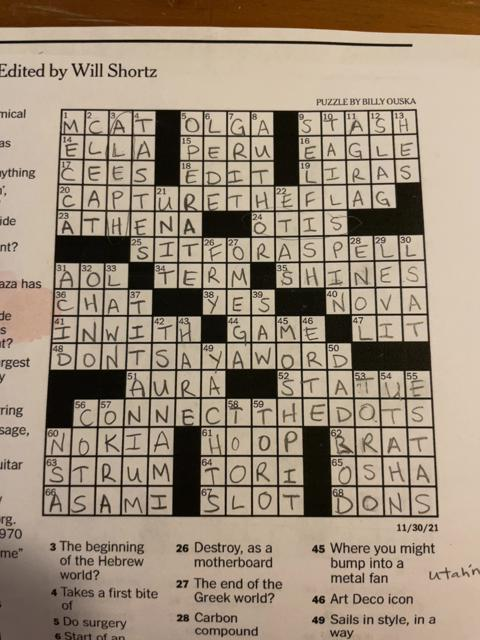

In [295]:
import cv2
import numpy as np

image = cv2.imread("../data/raw/1e30b83c-9dcc-4bba-87e2-cfc1c8218cf9.png")

# cv2 color channels are ordered BGR instead of RGB by default. rearrange color channels if you want a normal looking image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

showarray(image)
showarray(rgb)



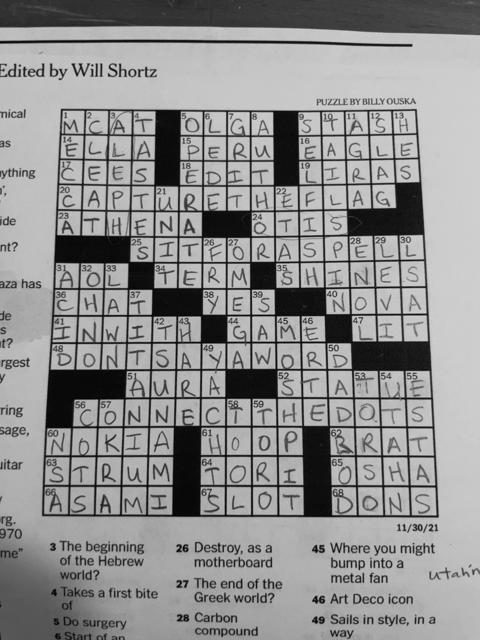

In [296]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
showarray(gray)

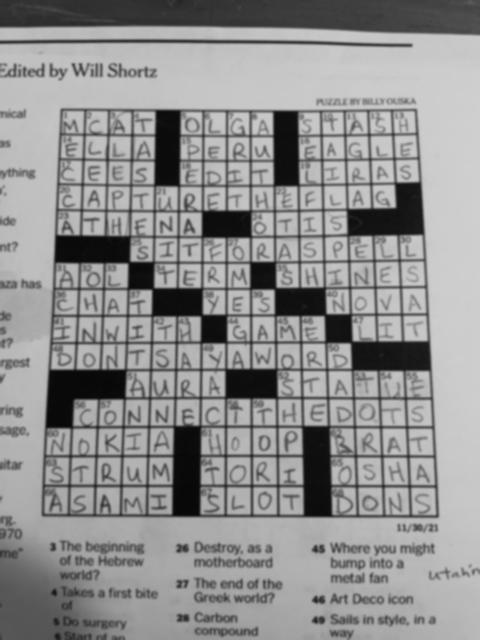

In [297]:
# blur the image to reduce noise
blur = cv2.GaussianBlur(gray, (5,5),0)
showarray(blur)

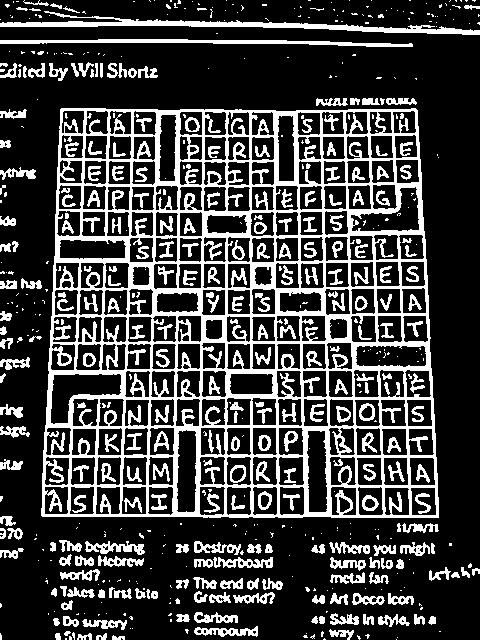

In [298]:
# apply thresholding to make everything black or white.  Adaptive thresholding is used to compensate for different lighting conditions across the image
thresh = cv2.adaptiveThreshold(blur,255,1,1,11,2)
showarray(thresh)

In [299]:
# find countours, the curves that joins all continuous points having the same color or intentsity
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

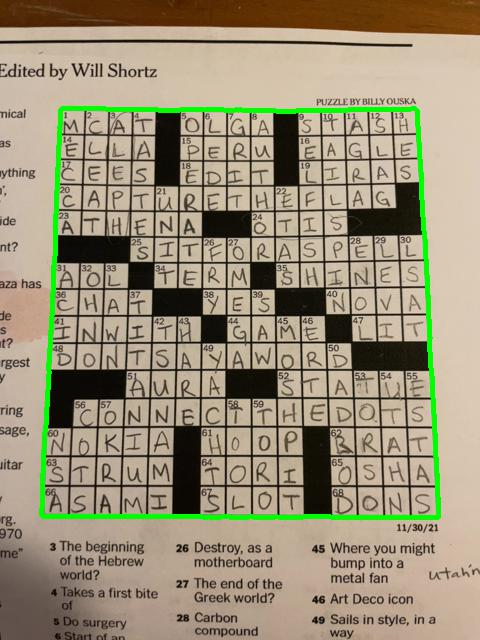

In [302]:
# we find the largest contour by area and assume this is the entire crossword grid
rgbcopy = rgb.copy()
max_area = 0
c = 0
for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
                if area > max_area:
                    max_area = area
                    best_cnt = i
                    rgb_c = cv2.drawContours(rgbcopy, contours, c, (0, 255, 0), 3)
                    
        c+=1
showarray(rgb_c)


In [332]:
# find the corners of the image
peri = cv2.arcLength(best_cnt, True)
corners = cv2.approxPolyDP(best_cnt, 0.04 * peri, True)
corners
# All points are in format [cols, rows]
pt_A = corners[0][0]
pt_B = corners[1][0]
pt_C = corners[2][0]
pt_D = corners[3][0]



In [333]:
# Calculate widths/heights using L2 norm
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

In [334]:
# map input points and output points after warping
input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

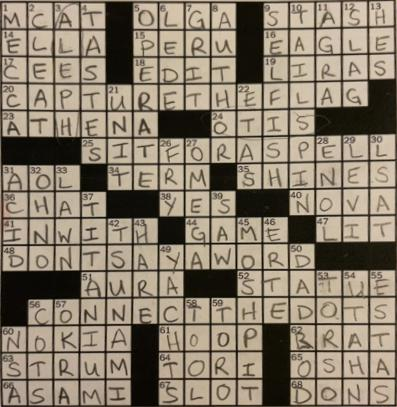

In [347]:
# Compute the perspective transform M
rgbcopy = rgb.copy()
M = cv2.getPerspectiveTransform(input_pts,output_pts)
warped = cv2.warpPerspective(rgbcopy,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
showarray(warped)

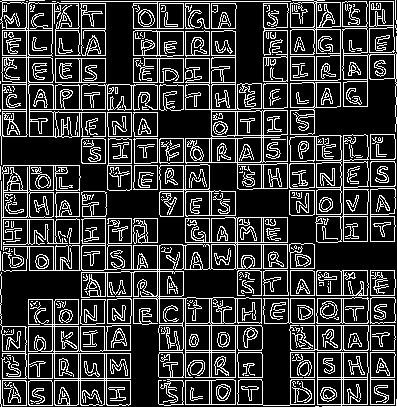

In [348]:
# find Canny edges
edges = cv2.Canny(warped, 50, 200)
showarray(edges)

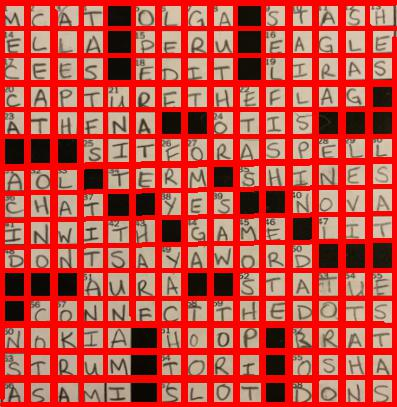

In [376]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 150, None, 5, 5000)
lined = warped.copy()

for line in lines:
    x1, y1, x2, y2 = line[0]
    # filter out non-vertical  and non horizontal lines
    angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi)

    if (angle >=0 and angle <= 10) or (angle >= 80 and angle <= 100):
        cv2.line(lined, (x1, y1), (x2, y2), (255, 0, 0), 3)

showarray(lined)

In [ ]:
# calculate average size box widths and heights, crop image